![Slide 1 - Decision Trees Title](../img/lecture06_decision_trees/slide-01.png)


# Lecture 06 — Decision Trees (Instructor Notes)

Welcome! This notebook is my spoken commentary in text form. It pairs each slide with a gentle explanation and small code steps that you can run and remix.


## How to Use This Notebook
- Read the short explanation under each slide image, then run the tiny code block that follows.
- I keep code cells small and commented so the flow is easy to follow.
- Mathematical ideas appear as clean equations using MathJax; feel free to click “Edit” on any Markdown cell to see the raw notation.


![Slide 3 - Learning to Generalize](../img/lecture06_decision_trees/slide-03.png)


## Slide 3 — Learning to Generalize
We train models so they make good predictions on **new** examples, not just the ones we showed them. Decision trees do this by asking a sequence of simple questions and following the answers down to a leaf.

Key terms:
- **Features**: observable facts about an example (e.g., color, temperature).
- **Label**: the answer to predict (today: the piece's shape).
- **Model**: a rule for mapping features → label (a tree of questions).


### The Pipeline, Demystified
The “data in → answers out” diagram on the slide hides the rule-making step. Here, that rule is a tree whose internal nodes are questions and whose leaves are predictions. We’ll start with a tiny, tactile example before we scale up.


![Slide 6 - Entropy and Information Gain](../img/lecture06_decision_trees/slide-06.png)


## Slide 6 — Entropy and Information Gain
Intuitively, **entropy** measures how mixed the labels are (how uncertain we are). If nearly every piece is a cube, there’s little surprise when we draw; if many shapes are equally likely, surprise is high.

Mathematically, for a random label \(Y\) with class probabilities \(p_1, p_2, \dots, p_k\), the (Shannon) entropy in bits is

$$
H(Y) = -\sum_{i=1}^{k} p_i \, \log_2 p_i.
$$

Two anchors for your intuition:
- Zero entropy when one outcome has probability 1.
- Maximum entropy when all outcomes are equally likely.


### Why Entropy Matters for Trees
At each node, a tree chooses the question that most reduces uncertainty about the label. That reduction is called **information gain**. Given a feature \(A\) with possible values \(v\), the conditional entropy is

$$
H(Y\mid A) = \sum_{v} \Pr(A{=}v)\, Higl(Y \mid A{=}vigr),
$$

and the information gain of splitting on \(A\) is

$$
\operatorname{IG}(Y; A) = H(Y) - H(Y\mid A).
$$

We will compute these quantities by hand first, then let a library do the same job for bigger datasets.


### Imports We Reuse
We’ll use pandas for tables, NumPy for arrays, matplotlib for plots, and scikit-learn for trees.


In [1]:
# Core libraries
import math
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, mean_squared_error

# Make plots easy to read
plt.style.use('seaborn-v0_8-whitegrid')


### Building Up Entropy Gently
We’ll start from probabilities, then examine special cases, and finally translate the same formula into reusable functions that accept labels or counts.


In [2]:
# Entropy given probabilities; normalizes if raw counts are supplied
# H(p) = - sum_i p_i log2 p_i

def entropy_from_probabilities(probabilities):
    total = sum(probabilities)
    if not math.isclose(total, 1.0):
        probabilities = [p / total for p in probabilities]
    return -sum(p * math.log2(p) for p in probabilities if p)


Let’s sweep the binary case (cube vs. coin) to see the classic dome-shaped curve.


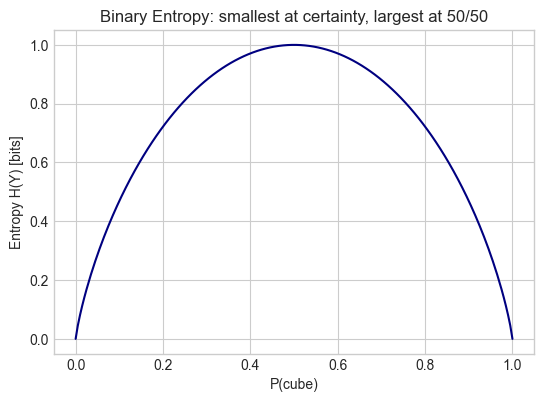

In [3]:
# Entropy as the probability of "cube" varies from 0 to 1
p_values = np.linspace(0.0, 1.0, 201)
H_binary = [entropy_from_probabilities([p, 1 - p]) for p in p_values]

plt.figure(figsize=(6.2, 4.2))
plt.plot(p_values, H_binary, color='navy')
plt.xlabel('P(cube)')
plt.ylabel('Entropy H(Y) [bits]')
plt.title('Binary Entropy: smallest at certainty, largest at 50/50')
plt.show()


A few numeric checkpoints for the binary case:
- \(H(0) = H(1) = 0\) (no surprise when the outcome is certain).
- \(H(0.5) = 1\) bit (the most uncertain, equally mixed case).


### From Probabilities to Data
Now we’ll turn the same idea into helpers that accept labels or raw counts directly:

- Given counts \((c_1, \dots, c_k)\), we use \(p_i = c_i / \sum_j c_j\).
- Given labels, we count them first and then apply the same formula.


In [4]:
# Entropy from class counts
# H = - sum_i (c_i / N) log2 (c_i / N)

def entropy_from_counts(counts):
    total = sum(counts)
    if total == 0:
        return 0.0
    return -sum((c / total) * math.log2(c / total) for c in counts if c)


In [5]:
# Entropy from a list/Series of labels
def entropy(labels):
    return entropy_from_counts(Counter(labels).values())


### Quick Sanity Checks
Pure vs. perfectly mixed bags should give \(0\) and \(1\) bit respectively in the two-class case.


In [6]:
# Scenario 1: certain outcome (entropy 0)
all_cubes = ['cube'] * 4
zero_entropy = entropy(all_cubes)

# Scenario 2: equally mixed (entropy 1 bit)
mixed = ['cube', 'cube', 'coin', 'coin']
one_bit = entropy(mixed)

zero_entropy, one_bit


(-0.0, 1.0)

### Conditional Entropy and Information Gain
Given a candidate question (feature \(A\)), we measure how much uncertainty remains after splitting on it:

$$
H(Y\mid A) = \sum_{v} \Pr(A{=}v)\, Higl(Y \mid A{=}vigr), \qquad
\operatorname{IG}(Y; A) = H(Y) - H(Y\mid A).
$$

We’ll implement exactly these two expressions in code.


In [7]:
# Conditional entropy H(Y|A) computed by grouping on feature values
def conditional_entropy(feature, target):
    total = len(target)
    groups = {}
    for f, y in zip(feature, target):
        groups.setdefault(f, []).append(y)
    return sum(len(vals) / total * entropy(vals) for vals in groups.values())


In [8]:
# Information gain: how much splitting on A reduces uncertainty in Y
def information_gain(feature, target):
    return entropy(target) - conditional_entropy(feature, target)


![Slide 8 - Board Game Inventory](../img/lecture06_decision_trees/slide-08.png)


## Slide 8 — Board Game Inventory (20-piece Bag)
We recorded each piece’s color, material, silhouette, and the true shape we want to predict. Our bag:

- 5 yellow cubes · 2 yellow coins · 2 red cubes · 2 red ships
- 1 red meeple · 3 red soldiers · 3 brown cubes · 1 brown pawn · 1 green cube

Our goal is to predict the **shape** from observed features.


### Building the Table
Each tuple below is `(color, material, silhouette, shape, count)`. We expand counts to one row per piece so the table mirrors the physical bag.


In [9]:
inventory_specs = [
    ('yellow', 'wood',   'blocky',    'cube',    5),
    ('yellow', 'metal',  'flat',      'coin',    2),
    ('red',    'wood',   'blocky',    'cube',    2),
    ('red',    'plastic','long',      'ship',    2),
    ('red',    'wood',   'character', 'meeple',  1),
    ('red',    'plastic','character', 'soldier', 3),
    ('brown',  'wood',   'blocky',    'cube',    3),
    ('brown',  'plastic','token',     'pawn',    1),
    ('green',  'wood',   'blocky',    'cube',    1),
]


In [10]:
rows = []
for color, material, silhouette, shape, count in inventory_specs:
    rows.extend({
        'color': color,
        'material': material,
        'silhouette': silhouette,
        'shape': shape,
    } for _ in range(count))

pieces = pd.DataFrame(rows)
pieces.head()


,color,material,silhouette,shape
0,yellow,wood,blocky,cube
1,yellow,wood,blocky,cube
2,yellow,wood,blocky,cube
3,yellow,wood,blocky,cube
4,yellow,wood,blocky,cube


### How Uncertain Are We, Initially?
Compute the label mix and its entropy/gini. Gini impurity is an alternative to entropy used by CART:

$$
\operatorname{Gini}(Y) = 1 - \sum_{i} p_i^2.
$$


In [11]:
shape_counts = pieces['shape'].value_counts()

# Gini impurity helper
def gini(labels):
    total = len(labels)
    counts = Counter(labels).values()
    return 1.0 - sum((c/total)**2 for c in counts)

bag_entropy = entropy(pieces['shape'])
bag_gini = gini(pieces['shape'])

shape_counts, bag_entropy, bag_gini


(shape
 cube       11
 soldier     3
 coin        2
 ship        2
 meeple      1
 pawn        1
 Name: count, dtype: int64,
 1.9814963295286754,
 0.6499999999999999)

![Slide 10 - Evaluating Splits](../img/lecture06_decision_trees/slide-10.png)


## Slide 10 — Evaluating Candidate Splits
At a node we pick the question with the largest information gain (or, equivalently, the largest decrease in impurity). We’ll compare three features: color, material, silhouette.


### Compute IG and Post-split Gini
We’ll compute both to show they tell a consistent story on this dataset.


In [12]:
features = ['color', 'material', 'silhouette']
records = []
for feat in features:
    ig = information_gain(pieces[feat], pieces['shape'])
    gini_after = sum(
        len(group)/len(pieces) * gini(group)
        for _, group in pieces.groupby(feat)['shape']
    )
    records.append({'feature': feat, 'information_gain': ig, 'weighted_gini': gini_after})

pd.DataFrame(records).sort_values('information_gain', ascending=False)


,feature,information_gain,weighted_gini
2,silhouette,1.819241,0.075000
1,material,1.295462,0.275000
0,color,0.754893,0.505357


Silhouette typically wins—it separates flat tokens from blocky cubes and character figures. Color and material help refine the remaining uncertainty.


![Slide 12 - First Levels of the Tree](../img/lecture06_decision_trees/slide-12.png)


## Slide 12 — First Levels of the Tree
Let’s fit a small tree (depth 2) so the picture stays readable and aligns with the slide.


### One-Hot Encoding and Fit
Scikit-learn expects numeric features. `pandas.get_dummies` turns categories into 0/1 columns.


In [13]:
X_small = pd.get_dummies(pieces[['color','material','silhouette']])
y_small = pieces['shape']

clf_small = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)
clf_small.fit(X_small, y_small)


DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)

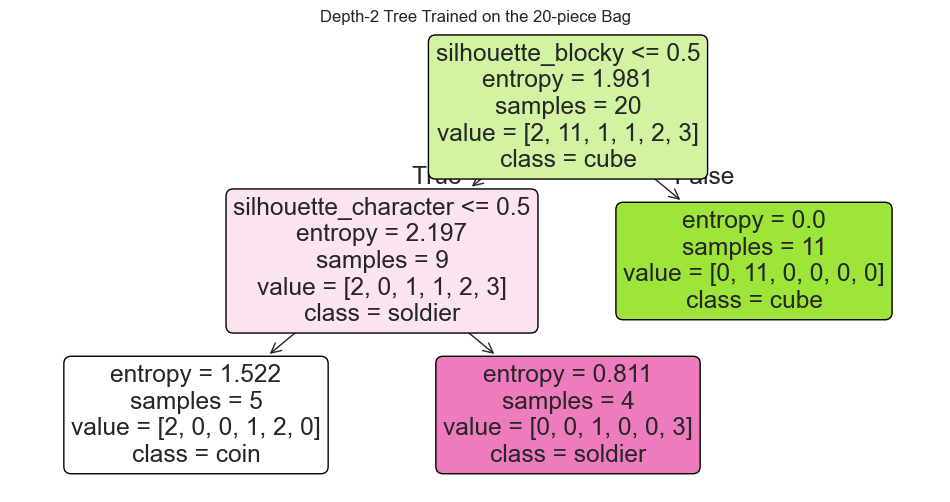

In [14]:
plt.figure(figsize=(12, 6))
plot_tree(
    clf_small,
    feature_names=X_small.columns,
    class_names=clf_small.classes_,
    filled=True,
    rounded=True,
    impurity=True,
)
plt.title('Depth-2 Tree Trained on the 20-piece Bag')
plt.show()


Notice how the root split mirrors the information-gain ranking. Leaves display class distributions and node impurity to make the connection to our formulas explicit.


![Slide 15 - Play Tennis Dataset](../img/lecture06_decision_trees/slide-15.png)


## Slide 15 — Play Tennis Example
A classic dataset to practice attribute selection. We’ll rebuild a tiny table and recompute entropy and information gain.


In [15]:
play_tennis_rows = [
    ('Sunny', 'Hot', 'High', 'Weak',   'No'),
    ('Sunny', 'Hot', 'High', 'Strong', 'No'),
    ('Overcast', 'Hot', 'High', 'Weak','Yes'),
    ('Rain', 'Mild', 'High', 'Weak',   'Yes'),
    ('Rain', 'Cool', 'Normal','Weak',  'Yes'),
    ('Rain', 'Cool', 'Normal','Strong','No'),
    ('Overcast','Cool','Normal','Strong','Yes'),
    ('Sunny', 'Mild', 'High', 'Weak',   'No'),
    ('Sunny', 'Cool', 'Normal','Weak',  'Yes'),
    ('Rain', 'Mild', 'Normal','Weak',   'Yes'),
    ('Sunny', 'Mild', 'Normal','Strong','Yes'),
    ('Overcast','Mild','High','Strong', 'Yes'),
    ('Overcast','Hot', 'Normal','Weak', 'Yes'),
    ('Rain', 'Mild', 'High', 'Strong',  'No'),
]
play_tennis = pd.DataFrame(play_tennis_rows, columns=['Outlook','Temperature','Humidity','Wind','Play'])
play_tennis


,Outlook,Temperature,Humidity,Wind,Play
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
5,Rain,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rain,Mild,Normal,Weak,Yes


In [16]:
H_play = entropy(play_tennis['Play'])
IGs = {col: information_gain(play_tennis[col], play_tennis['Play'])
       for col in ['Outlook','Temperature','Humidity','Wind']}
H_play, IGs


(0.9402859586706311,
 {'Outlook': 0.24674981977443933,
  'Temperature': 0.02922256565895487,
  'Humidity': 0.15183550136234159,
  'Wind': 0.04812703040826949})

`Outlook` has the largest information gain, which is why it appears at the root of hand-built trees for this dataset.


![Slide 18 - From Calculations to Code](../img/lecture06_decision_trees/slide-18.png)


## Slide 18 — From Hand Calculations to Tooling
Let scikit-learn automate the same choices once we one-hot encode the categorical features.


In [17]:
X_play = pd.get_dummies(play_tennis[['Outlook','Temperature','Humidity','Wind']])
y_play = play_tennis['Play']

clf_play = DecisionTreeClassifier(criterion='entropy', random_state=0)
clf_play.fit(X_play, y_play)


DecisionTreeClassifier(criterion='entropy', random_state=0)

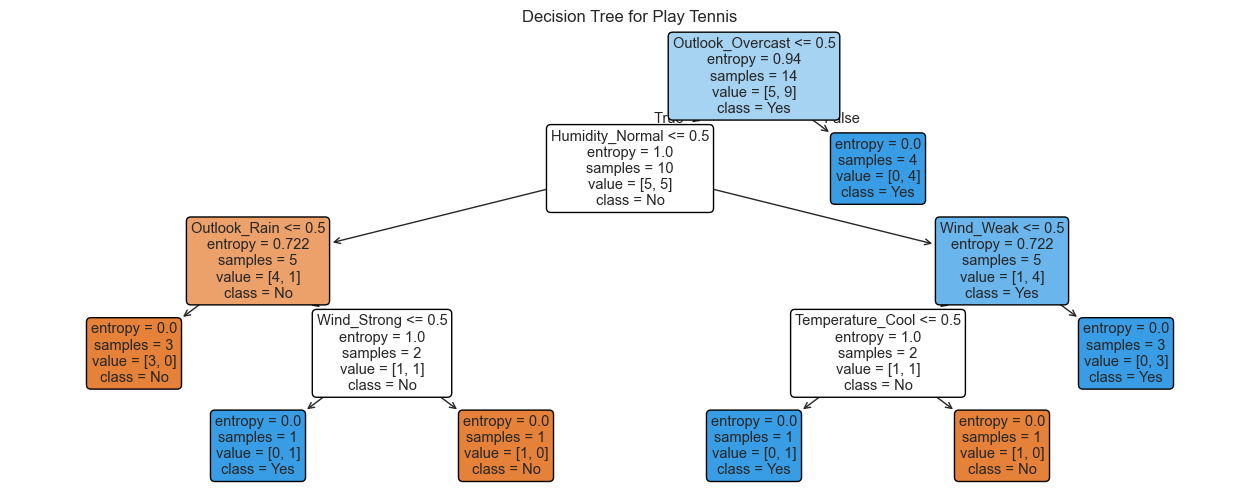

In [18]:
plt.figure(figsize=(16, 6))
plot_tree(clf_play, feature_names=X_play.columns, class_names=clf_play.classes_, filled=True, rounded=True)
plt.title('Decision Tree for Play Tennis')
plt.show()


![Slide 20 - Scaling Up with Iris](../img/lecture06_decision_trees/slide-20.png)


## Slide 20 — Scaling Up with Iris
We’ll compare training vs. test accuracy to see generalization in action.


In [19]:
iris = load_iris(as_frame=True)
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=7)

clf_iris = DecisionTreeClassifier(random_state=7)
clf_iris.fit(X_train, y_train)

train_acc = accuracy_score(y_train, clf_iris.predict(X_train))
test_acc = accuracy_score(y_test, clf_iris.predict(X_test))
train_acc, test_acc


(1.0, 0.9333333333333333)

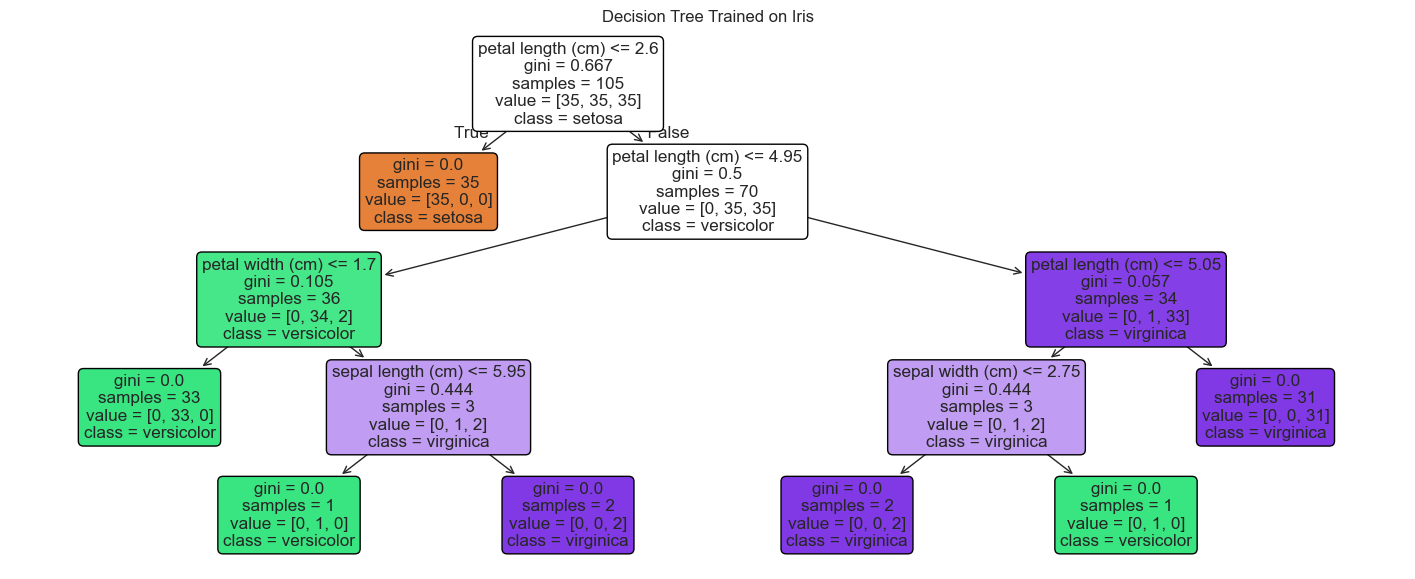

In [20]:
plt.figure(figsize=(18, 7))
plot_tree(clf_iris, feature_names=iris.feature_names, class_names=iris.target_names, filled=True, rounded=True)
plt.title('Decision Tree Trained on Iris')
plt.show()


![Slide 22 - Controlling Depth](../img/lecture06_decision_trees/slide-22.png)


## Slide 22 — Controlling Depth and Overfitting
As depth increases, training accuracy rises monotonically, but test accuracy typically peaks and then falls. We’ll sweep `max_depth`:


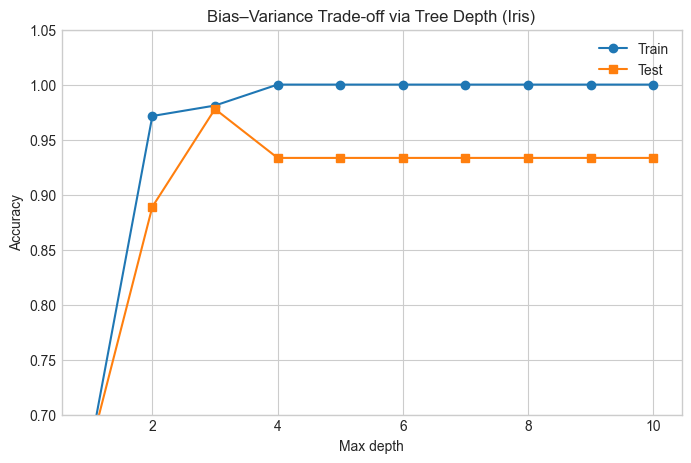

In [21]:
max_depths = range(1, 11)
train_scores, test_scores = [], []
for d in max_depths:
    m = DecisionTreeClassifier(max_depth=d, random_state=7)
    m.fit(X_train, y_train)
    train_scores.append(m.score(X_train, y_train))
    test_scores.append(m.score(X_test, y_test))

plt.figure(figsize=(8, 5))
plt.plot(max_depths, train_scores, marker='o', label='Train')
plt.plot(max_depths, test_scores, marker='s', label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Bias–Variance Trade-off via Tree Depth (Iris)')
plt.ylim(0.7, 1.05)
plt.legend()
plt.show()


![Slide 24 - Regression Trees](../img/lecture06_decision_trees/slide-24.png)


## Slide 24 — Regression Trees and Variance Reduction
In regression, we minimize **variance** within nodes rather than entropy/gini. For a real-valued target \(Y\), node impurity can be measured as

$$
\operatorname{Var}(Y) = rac{1}{n}\sum_{i=1}^n (y_i - ar y)^2.
$$

We’ll see how depth affects error on the diabetes dataset.


In [22]:
diabetes = load_diabetes(as_frame=True)
Xr = diabetes.data
yr = diabetes.target
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.3, random_state=11)

results = []
for depth in [1, 2, 4, 6, None]:
    reg = DecisionTreeRegressor(max_depth=depth, random_state=11)
    reg.fit(Xr_train, yr_train)
    rmse_train = mean_squared_error(yr_train, reg.predict(Xr_train), squared=False)
    rmse_test  = mean_squared_error(yr_test,  reg.predict(Xr_test),  squared=False)
    results.append({'max_depth': depth if depth is not None else 'full', 'rmse_train': rmse_train, 'rmse_test': rmse_test})

pd.DataFrame(results)


TypeError: got an unexpected keyword argument 'squared'

![Slide 26 - Key Takeaways](../img/lecture06_decision_trees/slide-26.png)


## Slide 26 — Key Takeaways
- Entropy and gini quantify “how mixed” labels are; information gain is the drop in that uncertainty when we split.
- Trees are interpretable because questions are human-readable; impurity numbers connect directly to the math.
- Depth and related knobs (min samples per leaf, etc.) regularize the model to avoid overfitting.
- The same framework extends to regression by swapping the impurity measure for variance.
